# Sky Saber + Velour Demo
Resources:
- [Images and annotations](https://demo01.chariot.striveworks.us/projects/2KVFMuUcjVJUHXGUNXnRVmaRxNq/datasets/2U7QIpKkOLhI0SDDaXptxWCiIjW?version=2VRqi9vpGSDUEOVPKbQy7B8uoNl)
- [Ship model](https://demo01.chariot.striveworks.us/projects/2FisBl1MgB7slir8zvf3uJ8BZOk/models/2V4z0nROtQOGO11vkfLdqEdwYLP)
- [Helicopter and plane model](https://demo01.chariot.striveworks.us/projects/2FisBl1MgB7slir8zvf3uJ8BZOk/models/2VfiKsH1GFKuifT1zxGnfowvwGC)


Before you run this notebook, be sure you have the following in your `sample_notebooks/skysaber` folder:
- `annotations.jsonl`
- `metadata.dat`
- `images/*.jpeg`

## Setup

In [1]:
# TODO clean up imports

from io import BytesIO
import json
import os
import pickle
import PIL.Image
import requests
from tqdm import tqdm

from velour.client import Client, ClientException
from velour.client import Dataset as VelourDataset, Model as VelourModel
from velour.viz import combined_segmentation_mask
from velour import enums

from velour.schemas import (
    Annotation,
    GroundTruth,
    ImageMetadata,
    Label,
    Raster,
    Point,
    BoundingBox,
    BasicPolygon,
    Metadatum
)

from chariot.client import connect
from chariot.datasets import Dataset as ChariotDataset
from chariot.models import Model as ChariotModel

from velour.integrations.chariot import get_chariot_model_integration

def _draw_bounding_boxes(image: PIL.Image, annotation: dict):
    """Helper function to draw bounding boxes on a Sky Saber image"""
    label = annotation['class_label']
    bb = ([annotation['bbox'][x] for x in ['xmin', 'ymin', 'xmax', 'ymax']])
    
    draw = PIL.ImageDraw.Draw(image)
    draw.rectangle((bb), outline="red")
    draw.text((bb[0], bb[1]), label)

    return image


def _load_image_from_annotation(annotation:dict) -> PIL.Image:
    """Return a PIL.Image for a given annotation"""
    image_path = f"./skysaber/images/{os.path.basename(annotation['path'])}"
    return PIL.Image.open(image_path)


def _load_image_from_image_metdata(img_metadata:ImageMetadata) -> PIL.Image:
    """Return a PIL.Image given an ImageMetadata object"""
    image_path = f"./skysaber/images/{img_metadata.uid}"
    return PIL.Image.open(image_path)



def _generate_groundtruth(annotation_obj: dict) -> GroundTruth:
    """Creates a Groundtruth using a Sky Saber annotation dictionary"""
    metadata_entry = metadata[annotation_obj['metadata_key']]
    height, width = _load_image_from_annotation(annotation_obj).size


    img_metadata = ImageMetadata(
        uid = annotation_obj['image_name'],
        height=height,
        width=width,
        metadata = [Metadatum(key=key, value=str(metadata_entry[key])) for key in approved_metadata]
    ).to_datum()

    img_annotations = []
    for annotation in annotation_obj['annotations']:
        label = annotation['class_label']

        img_annotations.append(Annotation(
                        task_type=enums.TaskType.DETECTION,
                        labels=[Label(key="class_label", value=label)],
                        metadata=[],
                        bounding_box=BoundingBox(
                            polygon=BasicPolygon(
                                points=[
                                    Point(x=annotation['bbox']['xmin'], y=annotation['bbox']['ymin']),
                                    Point(x=annotation['bbox']['xmax'], y=annotation['bbox']['ymin']),
                                    Point(x=annotation['bbox']['xmin'], y=annotation['bbox']['ymax']),
                                    Point(x=annotation['bbox']['xmax'], y=annotation['bbox']['ymax']),
                                ]
                            )
                        ),
                    )
        )

    gt = GroundTruth(
        datum=img_metadata,
        annotations=img_annotations
    )
    return gt

In [2]:
client = Client("http://localhost:8000")
N_IMAGES = 10

Succesfully connected to http://localhost:8000/.


# Ingest data

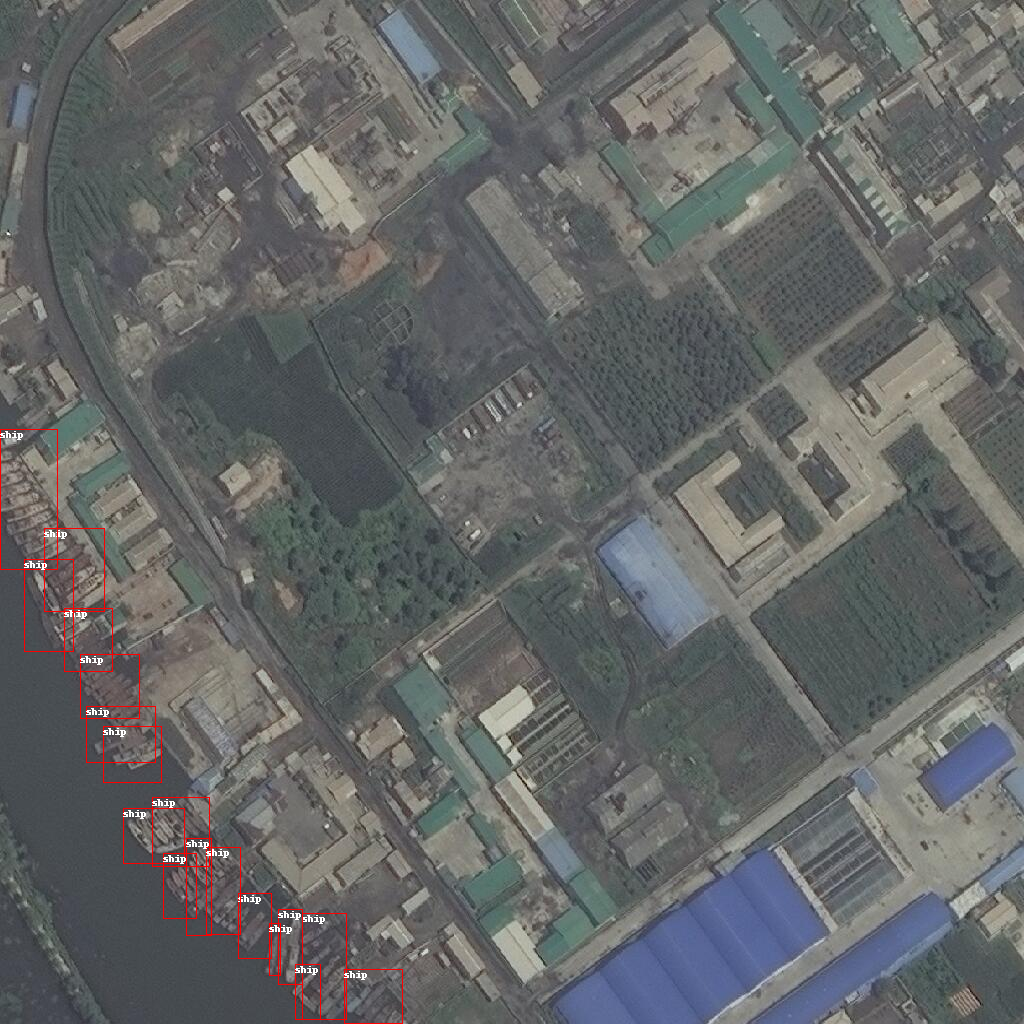

In [3]:
# setup metadata
metadata_path = "./skysaber/metadata.dat"   

with open(metadata_path, "rb") as f:
    raw_metadata = pickle.load(f)

metadata = {entry['id']:entry for entry in raw_metadata}


# setup annotations
with open("./skysaber/annotations.jsonl", 'r') as json_file:
    json_list = list(json_file)

annotations = []
i = 0

while len(annotations) < N_IMAGES:
    annotation = json.loads(json_list[i])
    annotation['metadata_key'] = os.path.basename(annotation['path']).split('_')[0]
    annotation['image_name'] = os.path.basename(annotation['path'])

    # only include an image if we have metadata for it
    if annotation['metadata_key'] in metadata.keys():
        annotations.append(annotation)

    i += 1
    

# show example(s)
for annotation_obj in annotations[:1]:
    image = _load_image_from_annotation(annotation_obj)
    for annotation in annotation_obj['annotations']:
        drawn_image = _draw_bounding_boxes(image=image, annotation=annotation)

    display(drawn_image)

## Add GroundTruths to Velour

In [26]:
dataset_name = "skysaber-demo"
approved_metadata = ['source', 'cloudCover', 'ageDays', 'acquisitionDate', 'colorBandOrder', 'offNadirAngle', 'groundSampleDistance', 'geometry']

# TODO geometry metadata is stored as a string, which probably isn't correct

client.delete_dataset(dataset_name, timeout=30)

dataset = VelourDataset.create(client, dataset_name)

for annotation_obj in annotations:
    gt = _generate_groundtruth(annotation_obj)
    annotation_obj['img_datum'] = gt.datum
    dataset.add_groundtruth(gt)

dataset.finalize()


<Response [200]>

In [27]:
dataset.get_datums()

[Datum(uid='089dc86dd09c08fae5f5cf8785f1ef02_20230816150750_c10_r13.jpeg', metadata=[Metadatum(key='width', value=1024.0), Metadatum(key='height', value=1024.0), Metadatum(key='source', value='WV02'), Metadatum(key='ageDays', value='527'), Metadatum(key='geometry', value="{'type': 'Polygon', 'coordinates': [[[128.146968, 40.5132975], [128.2777605, 40.524984], [128.408553, 40.5366705], [128.4076845, 40.23560025], [128.406816, 39.93453], [128.277603, 39.92174775], [128.14839, 39.9089655], [128.147679, 40.2111315], [128.146968, 40.5132975]]]}"), Metadatum(key='cloudCover', value='0.0023174956'), Metadatum(key='offNadirAngle', value='30.050774'), Metadatum(key='colorBandOrder', value='RGB'), Metadatum(key='acquisitionDate', value='2022-05-21 02:08:40'), Metadatum(key='groundSampleDistance', value='0.5')], dataset='skysaber-demo'),
 Datum(uid='089dc86dd09c08fae5f5cf8785f1ef02_20230816150750_c7_r16.jpeg', metadata=[Metadatum(key='width', value=1024.0), Metadatum(key='height', value=1024.0), 

In [28]:
dataset.get_images()

[ImageMetadata(uid='089dc86dd09c08fae5f5cf8785f1ef02_20230816150750_c10_r13.jpeg', height=1024, width=1024, dataset='skysaber-demo', metadata={'source': 'WV02', 'ageDays': '527', 'geometry': "{'type': 'Polygon', 'coordinates': [[[128.146968, 40.5132975], [128.2777605, 40.524984], [128.408553, 40.5366705], [128.4076845, 40.23560025], [128.406816, 39.93453], [128.277603, 39.92174775], [128.14839, 39.9089655], [128.147679, 40.2111315], [128.146968, 40.5132975]]]}", 'cloudCover': '0.0023174956', 'offNadirAngle': '30.050774', 'colorBandOrder': 'RGB', 'acquisitionDate': '2022-05-21 02:08:40', 'groundSampleDistance': '0.5'}),
 ImageMetadata(uid='089dc86dd09c08fae5f5cf8785f1ef02_20230816150750_c7_r16.jpeg', height=1024, width=1024, dataset='skysaber-demo', metadata={'source': 'WV02', 'ageDays': '527', 'geometry': "{'type': 'Polygon', 'coordinates': [[[128.146968, 40.5132975], [128.2777605, 40.524984], [128.408553, 40.5366705], [128.4076845, 40.23560025], [128.406816, 39.93453], [128.277603, 39

## Generate inferences

In [25]:
example_image_metdata = dataset.get_images()[0]

In [35]:
connect("https://demo01.chariot.striveworks.us/")
chariot_model = ChariotModel(name='ships-broad', project_name="Global")
velour_chariot_model, velour_chariot_parser = get_chariot_model_integration(client, chariot_model, "detect")

for annotation_obj in annotations: 
    image_metadata = annotation_obj['img_metadata']
    image = _load_image_from_image_metdata(image_metadata)

    result = chariot_model.detect(image)
    prediction = velour_chariot_parser(datum=image_metadata,
    result=result)
    
    velour_chariot_model.add_prediction(prediction)

velour_chariot_model.finalize_inferences(dataset)

AP Evaluation

In [35]:
chariot_eval1 = velour_yolo_model.evaluate_detection(
    dataset=velour_coco_dataset,
    label_key="name",
)

chariot_eval1.wait_for_completion(interval=0.5)

In [36]:
chariot_eval2 = velour_yolo_model.evaluate_detection(
    dataset=velour_coco_dataset,
    label_key="name",
    max_area=30*300
)

chariot_eval2.wait_for_completion(interval=0.5)

In [37]:
for m in chariot_eval1.metrics:
    print(m)

{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 1.0, 'label': {'key': 'name', 'value': 'bear'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 1.0, 'label': {'key': 'name', 'value': 'tv'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.6039603960396039, 'label': {'key': 'name', 'value': 'chair'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.504950495049505, 'label': {'key': 'name', 'value': 'person'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 1.0, 'label': {'key': 'name', 'value': 'clock'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.0, 'label': {'key': 'name', 'value': 'refrigerator'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.0, 'label': {'key': 'name', 'value': 'potted plant'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.25742574257425743, 'label': {'key': 'name', 'value': 'vase'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.0, 'label': {'key': 'name', 'value': 'dining table'}}
{'type': 'AP', 'parameters': 

In [38]:
for m in chariot_eval2.metrics:
    print(m)

{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.6039603960396039, 'label': {'key': 'name', 'value': 'chair'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.504950495049505, 'label': {'key': 'name', 'value': 'person'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 1.0, 'label': {'key': 'name', 'value': 'clock'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.0, 'label': {'key': 'name', 'value': 'refrigerator'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.0, 'label': {'key': 'name', 'value': 'potted plant'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 0.25742574257425743, 'label': {'key': 'name', 'value': 'vase'}}
{'type': 'AP', 'parameters': {'iou': 0.5}, 'value': 1.0, 'label': {'key': 'name', 'value': 'tv'}}
{'type': 'AP', 'parameters': {'iou': 0.75}, 'value': 0.40594059405940597, 'label': {'key': 'name', 'value': 'chair'}}
{'type': 'AP', 'parameters': {'iou': 0.75}, 'value': 0.504950495049505, 'label': {'key': 'name', 'value': 'person'}}
{'

# Clean-up

In [39]:
# velour_coco_dataset.delete()
# velour_yolo_model.delete()
# velour_chariot_model.delete()